In [47]:
import pandas as pd 
import numpy as np 
import os 
import requests
import joblib
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats 
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [48]:
# Specify the folder where the CSV files are located
directory = '/Users/blairjdaniel/lighthouse/lighthouse/NHL/files/goalies'

# Use glob to find all CSV files in the dir
csv_files = glob.glob(os.path.join(directory, '*.csv'))

# Initialize an empty dataframe
dataframes = []

# Loop through the CSV file and read it into a DF
for csv_file in csv_files:
    goalies = pd.read_csv(csv_file)
    dataframes.append(goalies)

    # # Check if the file is goalies_2010.csv and print a message
    # if 'goalies_2010.csv' in csv_file:
    #     print(f"goalies_2010.csv file loaded successfully.")
    #     print(goalies.head())  # Display the first few rows of the DataFrame


# Concatenate all DF into one master DataFrame
goalies_df = pd.concat(dataframes, ignore_index=True)
len(goalies_df)

7505

In [49]:
goalies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7505 entries, 0 to 7504
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   7505 non-null   int64  
 1   season                     7505 non-null   int64  
 2   name                       7505 non-null   object 
 3   team                       7505 non-null   object 
 4   position                   7505 non-null   object 
 5   situation                  7505 non-null   object 
 6   games_played               7505 non-null   int64  
 7   icetime                    7505 non-null   float64
 8   xGoals                     7505 non-null   float64
 9   goals                      7505 non-null   float64
 10  unblocked_shot_attempts    7505 non-null   float64
 11  xRebounds                  7505 non-null   float64
 12  rebounds                   7505 non-null   float64
 13  xFreeze                    7505 non-null   float

In [50]:
goalies_df.describe()

,playerId,season,games_played,icetime,xGoals,goals,unblocked_shot_attempts,xRebounds,rebounds,xFreeze,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
count,7.505000e+03,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,...,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000,7505.000000
mean,8.473670e+06,2015.797468,27.167222,36555.225316,27.253366,27.447302,568.583744,20.996617,22.917388,69.900011,...,25.149234,9.224919,9.745985,8.282502,9.469154,9.808128,8.170020,143.200666,0.567355,0.276482
std,5.070280e+03,4.627116,20.602839,56316.017814,39.778505,39.292510,869.928881,31.318161,35.324385,108.589718,...,36.052761,14.245283,14.620437,11.636614,14.616842,14.644998,11.465166,223.327008,1.692995,0.786285
min,8.448382e+06,2008.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.470880e+06,2012.000000,7.000000,2517.000000,1.930000,2.000000,32.000000,1.130000,1.000000,2.980000,...,2.000000,0.510000,0.670000,0.600000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
50%,8.474651e+06,2016.000000,25.000000,8354.000000,7.940000,8.000000,124.000000,5.250000,5.000000,14.010000,...,8.000000,1.980000,2.620000,2.980000,2.000000,3.000000,3.000000,30.000000,0.000000,0.000000
75%,8.476945e+06,2020.000000,43.000000,48210.000000,35.200000,37.000000,728.000000,27.820000,30.000000,91.720000,...,34.000000,12.190000,12.500000,11.850000,12.000000,13.000000,12.000000,180.000000,0.000000,0.000000
max,8.484312e+06,2023.000000,77.000000,267541.000000,217.670000,209.000000,4450.000000,168.820000,222.000000,555.090000,...,227.000000,75.810000,83.570000,78.930000,76.000000,91.000000,75.000000,1163.000000,25.000000,8.000000


In [51]:
goalies_df.columns.to_list()

['playerId',
 'season',
 'name',
 'team',
 'position',
 'situation',
 'games_played',
 'icetime',
 'xGoals',
 'goals',
 'unblocked_shot_attempts',
 'xRebounds',
 'rebounds',
 'xFreeze',
 'freeze',
 'xOnGoal',
 'ongoal',
 'xPlayStopped',
 'playStopped',
 'xPlayContinuedInZone',
 'playContinuedInZone',
 'xPlayContinuedOutsideZone',
 'playContinuedOutsideZone',
 'flurryAdjustedxGoals',
 'lowDangerShots',
 'mediumDangerShots',
 'highDangerShots',
 'lowDangerxGoals',
 'mediumDangerxGoals',
 'highDangerxGoals',
 'lowDangerGoals',
 'mediumDangerGoals',
 'highDangerGoals',
 'blocked_shot_attempts',
 'penalityMinutes',
 'penalties']

In [52]:
# Initialize an empty list to store DataFrames
pivoted_dfs = []
cols_to_drop = [
    'team'
]

# List of situations
situations = ['all']

# Loop through each situation and pivot the DataFrame
for situation in situations:
    # Filter the DataFrame for the specific situation
    situation_df = goalies_df[goalies_df['situation'] == situation]
    
    # Drop specific columns
    situation_df = situation_df.drop(columns=cols_to_drop)

    # Pivot the DataFrame
    pivoted_df = situation_df.pivot_table(index=['name', 'season'], aggfunc='first')
    
    # Flatten the columns
    pivoted_df.columns = [f'{col}' for col in pivoted_df.columns]
    
    # Reset the index
    pivoted_df = pivoted_df.reset_index()
    
    # Append the pivoted DataFrame to the list
    pivoted_dfs.append(pivoted_df)

# Merge all pivoted DataFrames into one master DataFrame
df_all = pivoted_dfs[0]
for pivoted_df in pivoted_dfs[1:]:
    df_all = df_all.merge(pivoted_df, on=['name', 'season'], how='outer')

In [53]:
df_all['position'] = np.where(df_all['position'].str.contains('G'), 'G', df_all['position'])

# Display the updated 'position' column
print(df_all['position'])

0       G
1       G
2       G
3       G
4       G
       ..
1495    G
1496    G
1497    G
1498    G
1499    G
Name: position, Length: 1500, dtype: object


In [54]:
# Use encoding to give the positions a numeric value
le = LabelEncoder()
df_all['position'] = df_all['position'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x) 

# Fit the encoder and transform the 'position' column
df_all['PositionEn_encoded'] = le.fit_transform(df_all['position'])
df_all = df_all.drop(columns=['position'])

In [55]:
df_all_grouped = df_all.groupby(by=['name']).agg({
    'playerId': 'first',  # Keep the first occurrence of 'playerId'
    'season': 'first',  # Keep the first occurrence of 'season'
    'PositionEn_encoded': 'first',  # Keep the first occurrence of 'position'
    'situation': 'first',  # Keep the first occurrence of 'situation'
    'games_played': 'sum',  # Sum the 'games_played' values
    'icetime': 'sum',  # Sum the 'icetime' values
    'xGoals': 'sum',  # Sum the 'xGoals' values
    'goals': 'sum',  # Sum the 'goals' values
    'unblocked_shot_attempts': 'sum',  # Sum the 'unblocked_shot_attempts' values
    'xRebounds': 'sum',  # Sum the 'xRebounds' values
    'rebounds': 'sum',  # Sum the 'rebounds' values
    'xFreeze': 'sum',  # Sum the 'xFreeze' values
    'freeze': 'sum',  # Sum the 'freeze' values
    'xOnGoal': 'sum',  # Sum the 'xOnGoal' values
    'ongoal': 'sum',  # Sum the 'ongoal' values
    'xPlayStopped': 'sum',  # Sum the 'xPlayStopped' values
    'playStopped': 'sum',  # Sum the 'playStopped' values
    'xPlayContinuedInZone': 'sum',  # Sum the 'xPlayContinuedInZone' values
    'playContinuedInZone': 'sum',  # Sum the 'playContinuedInZone' values
    'xPlayContinuedOutsideZone': 'sum',  # Sum the 'xPlayContinuedOutsideZone' values
    'playContinuedOutsideZone': 'sum',  # Sum the 'playContinuedOutsideZone' values
    'flurryAdjustedxGoals': 'sum',  # Sum the 'flurryAdjustedxGoals' values
    'lowDangerShots': 'sum',  # Sum the 'lowDangerShots' values
    'mediumDangerShots': 'sum',  # Sum the 'mediumDangerShots' values
    'highDangerShots': 'sum',  # Sum the 'highDangerShots' values
    'lowDangerxGoals': 'sum',  # Sum the 'lowDangerxGoals' values
    'mediumDangerxGoals': 'sum',  # Sum the 'mediumDangerxGoals' values
    'highDangerxGoals': 'sum',  # Sum the 'highDangerxGoals' values
    'lowDangerGoals': 'sum',  # Sum the 'lowDangerGoals' values
    'mediumDangerGoals': 'sum',  # Sum the 'mediumDangerGoals' values
    'highDangerGoals': 'sum',  # Sum the 'highDangerGoals' values
    'blocked_shot_attempts': 'sum',  # Sum the 'blocked_shot_attempts' values
    'penalityMinutes': 'sum',  # Sum the 'penalityMinutes' values
    'penalties': 'sum'  # Sum the 'penalties' values
}).reset_index()

# Convert the grouped DataFrame to a regular DataFrame
df_all_grouped

,name,playerId,season,PositionEn_encoded,situation,games_played,icetime,xGoals,goals,unblocked_shot_attempts,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
0,Aaron Dell,8477180,2016,0,all,130,411266.0,321.24,335.0,6491.0,...,296.0,102.91,124.38,93.95,105.0,139.0,91.0,1653.0,2.0,1.0
1,Adam Huska,8478903,2021,0,all,1,3582.0,3.14,7.0,69.0,...,2.0,0.78,1.35,1.01,1.0,5.0,1.0,19.0,0.0,0.0
2,Adam Werner,8479530,2019,0,all,2,5270.0,4.02,5.0,94.0,...,1.0,1.88,1.83,0.30,4.0,0.0,1.0,23.0,0.0,0.0
3,Adam Wilcox,8476330,2017,0,all,1,2319.0,1.13,0.0,30.0,...,0.0,0.38,0.74,0.00,0.0,0.0,0.0,6.0,0.0,0.0
4,Adin Hill,8478499,2017,0,all,136,443982.0,334.33,334.0,7279.0,...,313.0,117.08,113.86,103.40,131.0,115.0,88.0,2000.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,Yann Danis,8471186,2008,0,all,49,145237.0,116.96,113.0,2367.0,...,115.0,36.90,40.17,39.88,39.0,34.0,40.0,634.0,0.0,0.0
314,Yaroslav Askarov,8482137,2022,0,all,3,8370.0,7.88,6.0,148.0,...,11.0,2.00,2.93,2.93,2.0,3.0,1.0,42.0,0.0,0.0
315,Zach Fucale,8477457,2021,0,all,4,10295.0,7.39,5.0,142.0,...,8.0,2.34,2.64,2.42,3.0,0.0,2.0,40.0,0.0,0.0
316,Zach Sawchenko,8479313,2021,0,all,7,16138.0,16.02,15.0,284.0,...,14.0,4.41,6.35,5.27,3.0,7.0,5.0,72.0,0.0,0.0


In [56]:
# Create a dictionary for renaming columns
rename_dict = {
    'playerId': 'player_id',
    'season': 'season',
    
    'PositionEn_encoded': 'position',
    'situation': 'situation',
    'games_played': 'games_played',
    'icetime': 'icetime',
    'xGoals': 'x_goals',
    'goals': 'goals',
    'unblocked_shot_attempts': 'unblocked_shot_attempts',
    'xRebounds': 'x_rebounds',
    'rebounds': 'rebounds',
    'xFreeze': 'x_freeze',
    'freeze': 'freeze',
    'xOnGoal': 'x_on_goal',
    'ongoal': 'on_goal',
    'xPlayStopped': 'x_play_stopped',
    'playStopped': 'play_stopped',
    'xPlayContinuedInZone': 'x_play_continued_in_zone',
    'playContinuedInZone': 'play_continued_in_zone',
    'xPlayContinuedOutsideZone': 'x_play_continued_outside_zone',
    'playContinuedOutsideZone': 'play_continued_outside_zone',
    'flurryAdjustedxGoals': 'flurry_adjusted_x_goals',
    'lowDangerShots': 'low_danger_shots',
    'mediumDangerShots': 'medium_danger_shots',
    'highDangerShots': 'high_danger_shots',
    'lowDangerxGoals': 'low_danger_x_goals',
    'mediumDangerxGoals': 'medium_danger_x_goals',
    'highDangerxGoals': 'high_danger_x_goals',
    'lowDangerGoals': 'low_danger_goals',
    'mediumDangerGoals': 'medium_danger_goals',
    'highDangerGoals': 'high_danger_goals',
    'blocked_shot_attempts': 'blocked_shot_attempts',
    'penalityMinutes': 'penalty_minutes',
    'penalties': 'penalties'
}

# Rename the columns
df_all_grouped = df_all_grouped.rename(columns=rename_dict)

# Display the resulting DataFrame
goalie_df = df_all_grouped.drop(columns=['situation', 'player_id', 'season'])
goalie_df

,name,position,games_played,icetime,x_goals,goals,unblocked_shot_attempts,x_rebounds,rebounds,x_freeze,...,high_danger_shots,low_danger_x_goals,medium_danger_x_goals,high_danger_x_goals,low_danger_goals,medium_danger_goals,high_danger_goals,blocked_shot_attempts,penalty_minutes,penalties
0,Aaron Dell,0,130,411266.0,321.24,335.0,6491.0,241.61,280.0,787.32,...,296.0,102.91,124.38,93.95,105.0,139.0,91.0,1653.0,2.0,1.0
1,Adam Huska,0,1,3582.0,3.14,7.0,69.0,2.42,2.0,8.21,...,2.0,0.78,1.35,1.01,1.0,5.0,1.0,19.0,0.0,0.0
2,Adam Werner,0,2,5270.0,4.02,5.0,94.0,3.70,1.0,11.34,...,1.0,1.88,1.83,0.30,4.0,0.0,1.0,23.0,0.0,0.0
3,Adam Wilcox,0,1,2319.0,1.13,0.0,30.0,0.95,0.0,3.70,...,0.0,0.38,0.74,0.00,0.0,0.0,0.0,6.0,0.0,0.0
4,Adin Hill,0,136,443982.0,334.33,334.0,7279.0,259.12,321.0,893.25,...,313.0,117.08,113.86,103.40,131.0,115.0,88.0,2000.0,4.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,Yann Danis,0,49,145237.0,116.96,113.0,2367.0,84.79,82.0,273.44,...,115.0,36.90,40.17,39.88,39.0,34.0,40.0,634.0,0.0,0.0
314,Yaroslav Askarov,0,3,8370.0,7.88,6.0,148.0,5.38,11.0,18.63,...,11.0,2.00,2.93,2.93,2.0,3.0,1.0,42.0,0.0,0.0
315,Zach Fucale,0,4,10295.0,7.39,5.0,142.0,5.35,7.0,16.72,...,8.0,2.34,2.64,2.42,3.0,0.0,2.0,40.0,0.0,0.0
316,Zach Sawchenko,0,7,16138.0,16.02,15.0,284.0,10.71,14.0,35.07,...,14.0,4.41,6.35,5.27,3.0,7.0,5.0,72.0,0.0,0.0


In [57]:
goalie_df = goalie_df[goalie_df['games_played'] > 100]
goalie_df

,name,position,games_played,icetime,x_goals,goals,unblocked_shot_attempts,x_rebounds,rebounds,x_freeze,...,high_danger_shots,low_danger_x_goals,medium_danger_x_goals,high_danger_x_goals,low_danger_goals,medium_danger_goals,high_danger_goals,blocked_shot_attempts,penalty_minutes,penalties
0,Aaron Dell,0,130,411266.0,321.24,335.0,6491.0,241.61,280.0,787.32,...,296.0,102.91,124.38,93.95,105.0,139.0,91.0,1653.0,2.0,1.0
4,Adin Hill,0,136,443982.0,334.33,334.0,7279.0,259.12,321.0,893.25,...,313.0,117.08,113.86,103.40,131.0,115.0,88.0,2000.0,4.0,2.0
6,Al Montoya,0,168,548999.0,404.78,405.0,8359.0,302.18,314.0,988.74,...,381.0,136.27,143.96,124.55,143.0,159.0,103.0,2190.0,12.0,6.0
9,Alex Nedeljkovic,0,141,469332.0,374.70,386.0,7520.0,284.13,330.0,948.63,...,337.0,123.75,142.14,108.82,135.0,144.0,107.0,1859.0,8.0,4.0
10,Alex Stalock,0,179,575513.0,392.64,432.0,8851.0,320.51,314.0,1088.30,...,348.0,144.68,136.29,111.65,149.0,150.0,133.0,2290.0,18.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Tristan Jarry,0,257,867610.0,643.68,651.0,13445.0,497.77,575.0,1697.10,...,626.0,212.07,228.12,203.52,209.0,252.0,190.0,3373.0,24.0,11.0
302,Tuukka Rask,0,560,1931571.0,1310.51,1221.0,28336.0,1031.64,876.0,3537.73,...,1135.0,454.24,475.08,381.20,419.0,421.0,381.0,6912.0,26.0,13.0
303,Ty Conklin,0,105,342204.0,231.48,264.0,4759.0,180.13,135.0,584.21,...,168.0,87.60,88.69,55.17,100.0,99.0,65.0,1059.0,12.0,6.0
309,Ville Husso,0,132,449502.0,361.08,376.0,7293.0,274.58,360.0,915.32,...,356.0,121.95,125.44,113.68,160.0,129.0,87.0,1834.0,4.0,3.0


In [58]:
# Check for duplicate column names
duplicate_columns = goalie_df.columns[goalie_df.columns.duplicated()].unique()
if len(duplicate_columns) > 0:
    print(f"Duplicate columns found: {duplicate_columns}")
    # Optionally, you can rename or drop the duplicate columns here
    # For example, you can drop the duplicate columns
    goalie_df = goalie_df.loc[:, ~goalie_df.columns.duplicated()]


# Identify the columns to average per game
columns_to_average = goalie_df.columns.difference(['name', 'position', 'games_played'])

# Divide each identified column by the 'games_played_all' column
for col in columns_to_average:
    goalie_df[col] = goalie_df[col] / goalie_df['games_played']

# Display the resulting DataFrame
goalie_df = goalie_df.drop(columns=['games_played', 'position'])
goalie_df.head(20)

/var/folders/2m/_3np4g752dzdn21lzc5c7nsm0000gn/T/ipykernel_95359/1216744755.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goalie_df[col] = goalie_df[col] / goalie_df['games_played']


,name,icetime,x_goals,goals,unblocked_shot_attempts,x_rebounds,rebounds,x_freeze,freeze,x_on_goal,...,high_danger_shots,low_danger_x_goals,medium_danger_x_goals,high_danger_x_goals,low_danger_goals,medium_danger_goals,high_danger_goals,blocked_shot_attempts,penalty_minutes,penalties
0,Aaron Dell,3163.584615,2.471077,2.576923,49.930769,1.858538,2.153846,6.056308,5.707692,26.658000,...,2.276923,0.791615,0.956769,0.722692,0.807692,1.069231,0.700000,12.715385,0.015385,0.007692
4,Adin Hill,3264.573529,2.458309,2.455882,53.522059,1.905294,2.360294,6.568015,6.375000,27.792868,...,2.301471,0.860882,0.837206,0.760294,0.963235,0.845588,0.647059,14.705882,0.029412,0.014706
6,Al Montoya,3267.851190,2.409405,2.410714,49.755952,1.798690,1.869048,5.885357,6.315476,26.022202,...,2.267857,0.811131,0.856905,0.741369,0.851190,0.946429,0.613095,13.035714,0.071429,0.035714
9,Alex Nedeljkovic,3328.595745,2.657447,2.737589,53.333333,2.015106,2.340426,6.727872,6.673759,29.133333,...,2.390071,0.877660,1.008085,0.771773,0.957447,1.021277,0.758865,13.184397,0.056738,0.028369
10,Alex Stalock,3215.156425,2.193520,2.413408,49.446927,1.790559,1.754190,6.079888,5.731844,26.235363,...,1.944134,0.808268,0.761397,0.623743,0.832402,0.837989,0.743017,12.793296,0.100559,0.055866
11,Alexandar Georgiev,3381.275591,2.731496,2.685039,54.307087,2.049331,2.696850,6.753661,6.393701,29.127205,...,2.850394,0.867047,0.937126,0.927441,1.015748,0.881890,0.787402,13.673228,0.023622,0.015748
16,Anders Lindback,3158.800000,2.275769,2.515385,48.492308,1.824923,1.561538,6.036846,5.992308,26.556231,...,1.807692,0.823538,0.840846,0.611308,0.753846,0.969231,0.792308,11.484615,0.046154,0.023077
17,Anders Nilsson,3307.583851,2.691925,2.826087,55.242236,2.073665,2.043478,6.797205,6.906832,29.994161,...,2.329193,0.934534,0.989441,0.767764,0.987578,1.105590,0.732919,13.180124,0.037267,0.018634
18,Andrei Vasilevskiy,3521.392034,2.700503,2.511530,54.020964,2.062893,2.125786,6.630168,6.111111,29.192914,...,2.433962,0.893564,0.996352,0.810524,0.895178,0.907757,0.708595,13.234801,0.050314,0.025157
22,Antero Niittymaki,3357.657143,2.590381,2.609524,51.428571,1.972095,2.219048,6.243905,5.980952,27.968762,...,2.638095,0.888381,0.811143,0.891048,0.866667,0.771429,0.971429,12.314286,0.038095,0.019048


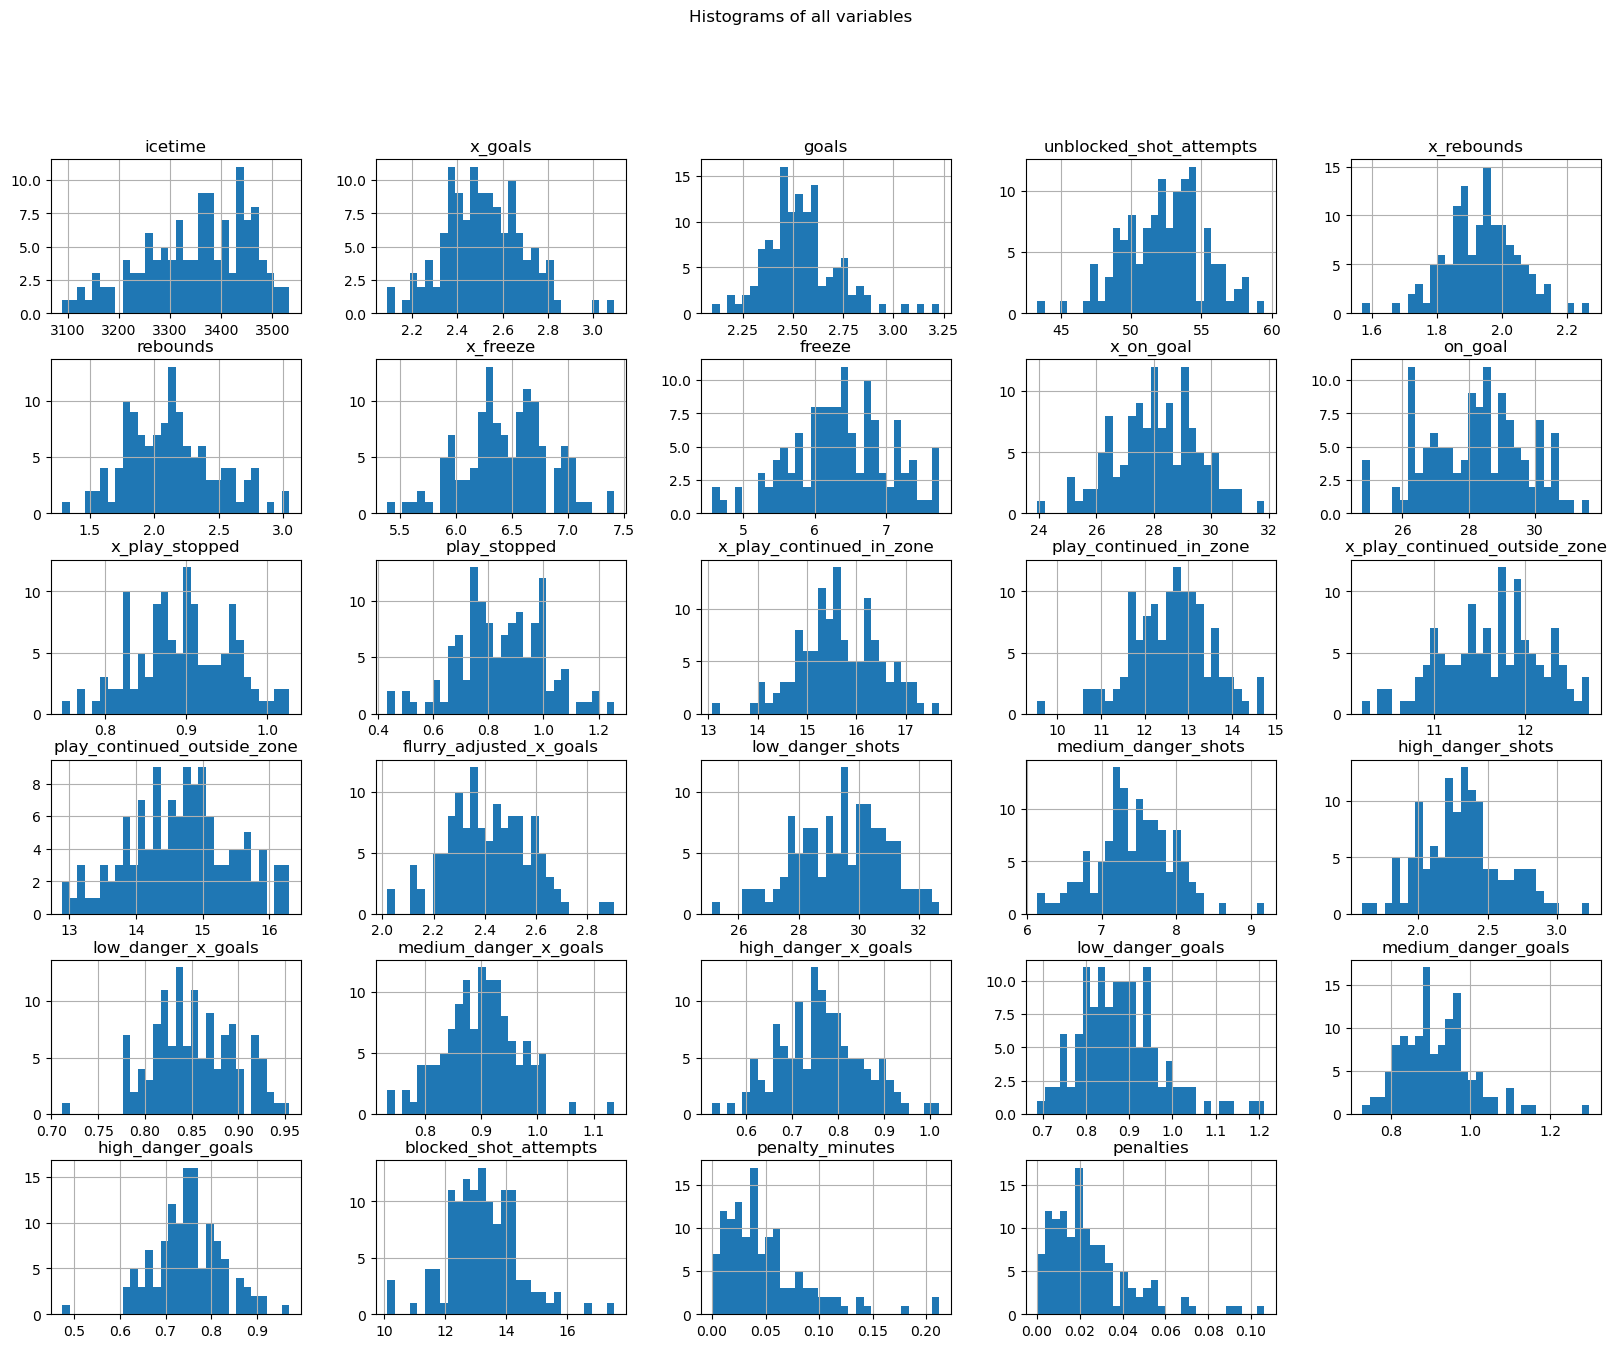

In [59]:
# Histogram for each variable
goalie_df.hist(bins=30, figsize=(20, 15))
plt.suptitle('Histograms of all variables')
plt.show()

In [63]:
# Select the features to use for the recommender engine
features = [
    
    'icetime',
    'x_goals',
    'goals',
    'unblocked_shot_attempts',
    'x_rebounds',
    'rebounds',
    'x_freeze',
    'freeze',
    'x_on_goal',
    'on_goal',
    'x_play_stopped',
    'play_stopped',
    'x_play_continued_in_zone',
    'play_continued_in_zone',
    'x_play_continued_outside_zone',
    'play_continued_outside_zone',
    'flurry_adjusted_x_goals',
    'low_danger_shots',
    'medium_danger_shots',
    'high_danger_shots',
    'low_danger_x_goals',
    'medium_danger_x_goals',
    'high_danger_x_goals',
    'low_danger_goals',
    'medium_danger_goals',
    'high_danger_goals',
    'blocked_shot_attempts',
    'penalty_minutes',
    'penalties'
]

In [64]:
goalie_pca = goalie_df.copy()

In [65]:
# Scale the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(goalie_df[features])

<Axes: >

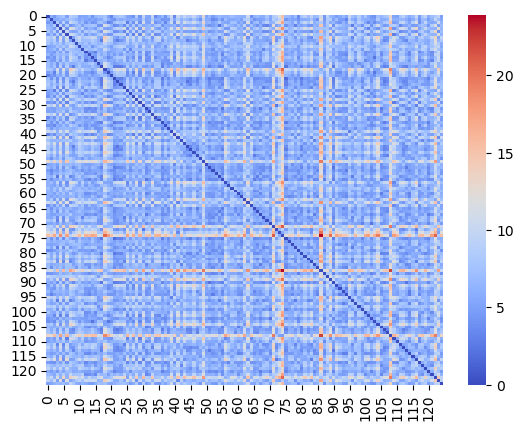

In [66]:
# Calculate euclidean distances
goalie_dist = euclidean_distances(scaled_features)

sns.heatmap(goalie_dist, cmap='coolwarm')

<Axes: >

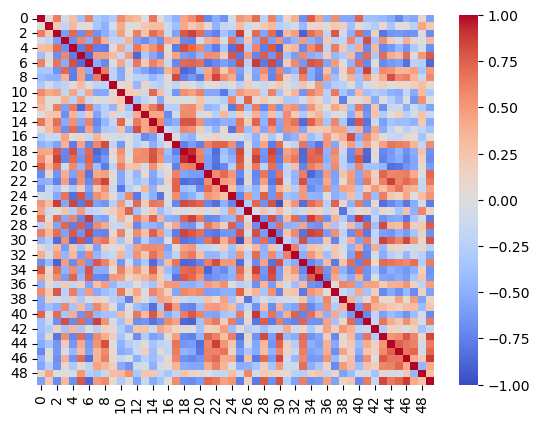

In [68]:
# Calculate cosine similarities
goalie_sims = cosine_similarity(scaled_features)

sns.heatmap(goalie_sims[:50, :50], cmap='coolwarm', vmin=-1, vmax=1)

In [72]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # Adjust the number of components as needed
pca_features = pca.fit_transform(scaled_features)

# Create a new DataFrame with the PCA features
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])
pca_df['name'] = goalie_df['name'].values


In [73]:
# Function to find the 5 closest players
def find_closest_players(player_name, df, n=5):
    # Get the feature values for the target player
    target_player = df[df['name'] == player_name].drop(columns=['name'])
    
    # Calculate the Euclidean distances between the target player and all other players
    distances = euclidean_distances(df.drop(columns=['name']), target_player).flatten()
    
    # Get the indices of the 5 closest players
    closest_indices = np.argsort(distances)[1:n+1]  # Exclude the target player itself
    
    # Get the player names of the closest players
    closest_players = df.iloc[closest_indices][['name']]
    
    return closest_players

In [76]:
# Example usage
target_player_name = 'Sergei Bobrovsky'  # Replace with the target player's name
closest_players = find_closest_players(target_player_name, pca_df)

# Display the closest players
print(f'Because you like {target_player_name}, you might also enjoy these similar players: {closest_players}')

Because you like Sergei Bobrovsky, you might also enjoy these similar players:                   name
90         Matt Murray
51     Jacob Markstrom
17       Braden Holtby
55      Jaroslav Halak
8   Andrei Vasilevskiy
